# Homework 6

## FINM 36700 - 2023

### UChicago Financial Mathematics

**Professor**
* Mark Hendricks
* hendricks@uchicago.edu

**Students**

Kaleem Bukhari kbukhari@uchicago.edu

Aditya Murarka adityam@uchicago.edu

Raafay Uqaily raafay@uchicago.edu

Shrey Jain shreyjain@uchicago.edu

Tikhonov Sergei tikhonov@uchicago.edu


## Modules

In [1]:
import os
import pandas as pd
from scipy.stats import norm
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from arch.univariate import GARCH
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

import matplotlib.pyplot as plt

## Helping functions

In [2]:
def performance_summary(return_data, factors, corr):

    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*12)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(12))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    summary_stats['Skewness'] = return_data.skew()
    
    summary_stats['corr to MKT'] = pd.concat([factors, return_data], axis = 1).corr().loc['MKT', corr]
    summary_stats['corr to HML'] = pd.concat([factors, return_data], axis = 1).corr().loc['HML', corr]

    return summary_stats

## Data Reading

In [3]:
factors = pd.read_excel('momentum_data.xlsx', sheet_name = 'factors (excess returns)', index_col = 'Date')
momentum = pd.read_excel('momentum_data.xlsx', sheet_name = 'momentum (excess returns)', index_col = 'Date')

size_ports = pd.read_excel('momentum_data.xlsx', sheet_name = 'size_sorts (total returns)', index_col = 'Date')
deciles = pd.read_excel('momentum_data.xlsx', sheet_name = 'deciles (total returns)', index_col = 'Date')

rf = pd.read_excel('momentum_data.xlsx', sheet_name = 'risk-free rate', index_col = 'Date')

## 2) Investigating Momentum

#### In this section, we empirically investigate some concerns regarding AQR’s new momentum product.

#### On GitHub, find the data file, “momentum data.xlsx”.


- #### The third tab contains the momentum factor as an excess return: $\tilde{r}^{mom}$


- #### The fourth tab contains returns on portfolios corresponding to scored momentum deciles.
    - #### $\tilde{r}^{mom(1)}$ denotes the portfolio of stocks in the lowest momentum decile, the “losers” with the lowest past returns.
    - #### $\tilde{r}^{mom(10)}$ denotes the portfolio of stocks in the highest momentum decile.


- #### The fifth tab gives portfolios sorted by momentum and size.
    - #### $\tilde{r}^{momSU}$ denotes the portfolio of small stocks in the top 3 deciles of momentum scores.
    - #### $\tilde{r}^{momBD}$ denotes the portfolio of big-stocks in the bottom 3 deciles of momentum scores.


#### Note that the Fama-French momentum return, $\tilde{r}^{mom:FF}$, given in the third tab, is constructed by FF as,


#### $$\tilde{r}^{mom:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − \frac{1}{2} (\tilde{r}^{momBD} + \tilde{r}^{momSD}) $$

### 2.1.a) Is momentum still profitable?

The excess returns of lucrative trading strategies often disappear once the strategy is well-known. The first widely-cited paper on momentum was published in 1993. Have momentum returns or risk changed since then? The AQR case takes place at the end of 2008. Have momentum returns changed in 2009-2021?


Investigate by filling out the summary statistics below for the full-sample and three sub-samples.

(a) Using the data provided, fill in Table 1 with the appropriate stats for $\tilde{r}^{mom:FF}$

|<caption>Table 1: Momentum performance over time.</caption>|Subsample|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|
|1927 - 2022|||||||||
|1927 - 1993|||||||||
|1994 - 2008|||||||||
|2009 - 2022|||||||||


In [4]:
time_period = [['1927','2023'], ['1927','1993'], ['1994','2008'], ['2009','2023']]
momentum_performance = []

for period in time_period:
    summary = performance_summary(momentum.loc[period[0]:period[1]], factors.loc[period[0]:period[1]], 'UMD')
    summary.index = [f'{period[0]}-{period[1]}']
    momentum_performance.append(summary)

pd.concat(momentum_performance)

,Mean,Volatility,Sharpe Ratio,Skewness,corr to MKT,corr to HML
1927-2023,0.074791,0.163069,0.458647,-2.992077,-0.346337,-0.404836
1927-1993,0.090113,0.159991,0.563242,-3.808977,-0.362537,-0.494960
1994-2008,0.104373,0.175551,0.594548,-0.582038,-0.234519,-0.129402
2009-2023,-0.026030,0.161623,-0.161052,-2.698287,-0.385511,-0.309380


### 2.1.b) Has momentum changed much over time, as seen through these subsample statistics?

**Answer**:

Both 1927-1993 and 1994-2008 subsamples show the very same mean, volatility, sharpe ratio and relatively close correlation coefficients. The only big difference in the statistics is skewness, which is 6 time larger in 1927-1993 compared to 1994-2008.

However, in 2009-2023 subsample mean becomes negative, and with the relatively similar volatility, sharpe ratio also changed dramatically. Skewness returns to its fullsample levels, while the correlation with HML decreased slightly (ins abs value compared to the whole sample). 

### 2.1.c) Does this data support AQR's argument that momentum is an important piece of the ideal portfolio? What if mean returns to momentum are in actuality near zero due to transaction costs - would there still be evidence here that momentum is valuable?

**Answer**:

Considering the whole sample data, Momentum is indeed important factor, because it has shown stable positive returns with relatively low correlation to other factors. The only exception is 2009-2022 sample. Such a change of tendency can be explained by the series of economic crises with corresponding economic policies.

### 2.2) The case is about whether a long-only implementation of momentum is valuable.

#### Construct your own long-only implementation:

#### $$\tilde{r}^{momU:FF} = \frac{1}{2} (\tilde{r}^{momBU} + \tilde{r}^{momSU}) − r^f $$

#### Note that this is following the FF approach of treating big and small stocks separately. This would be very similar to a scaled version of,

#### $$\tilde{r}^{momU} = \frac{1}{3} (\tilde{r}^{mom(8)} + \tilde{r}^{mom(9)} + \tilde{r}^{mom(10)}) − r^f $$


#### For the question below, use the FF-style $\tilde{r}^{momU:FF}_t$


### 2.2.a) Fill out Table 2 for the data in the period 1994-2022.


|<caption>Table 2: Long-only momentum performance.</caption>|1994-2022|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|Long-and-short, $\tilde{r}^{mom:FF}$|||||||||
|Long only, $\tilde{r}^{momU:FF}$|||||||||


In [5]:
long_and_short = (1/2) * (size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR'])\
                                        - (1/2) * (size_ports['BIG LoPRIOR'] + size_ports['SMALL LoPRIOR'])
long_and_short = pd.DataFrame(long_and_short.loc['1994':], columns = ['Long-and-short'])

long_only = (1/2) * (size_ports['BIG HiPRIOR'] + size_ports['SMALL HiPRIOR']) - rf['RF']
long_only = pd.DataFrame(long_only.loc['1994':], columns = ['Long-only'])

construction_summary = []

summary_ls = performance_summary(long_and_short, factors, 'Long-and-short')
summary_l = performance_summary(long_only, factors, 'Long-only')
construction_summary.append(summary_ls)
construction_summary.append(summary_l)
pd.concat(construction_summary)

,Mean,Volatility,Sharpe Ratio,Skewness,corr to MKT,corr to HML
Long-and-short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Long-only,0.115447,0.178350,0.647306,-0.463528,0.901697,-0.130850


### 2.2.b) Is long-only momentum as attractive as long-short momentum with respect to mean, volatility, and Sharpe Ratio?

**Answer**:

1. Mean returns sufficiently lower in Long-and-short strategy than in Long-only.
2. Adjusted to volatility returns are 3 times higher for Long-only strategy

As a result, Long-only strategy looks much more attractive than long-and-short strategy. However, it's worth mentioning that long-only strategy has a substantial correlation with market factor. Taking into account this fact, long-only strategy is not that useful.

### 2.2.c) Is long-only momentum as diversifying as long-short momentum with respect to market and value premia?

**Answer**:

1. Correlation: since the long-only momentum has high correlation with market factor, it is considered to be not diversifying

2. Volatility: long-and-short momentum has much lower volatility than long-only, so again long-only is not diversifying 

### 2.2.d) Show a plot of the cumulative product of 1 + $\tilde{r}^{mom:FF}$ and 1 + $\tilde{r}^{momU:FF}$  over the 1994-2022 subsample.

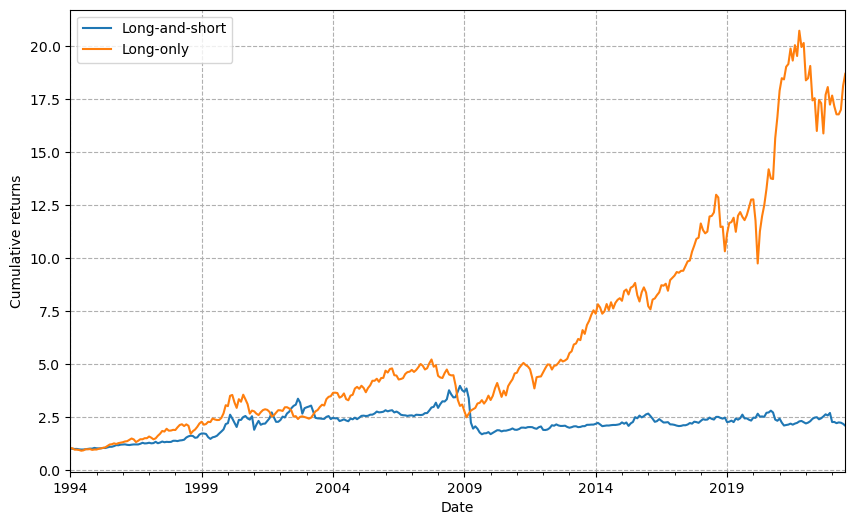

In [6]:
graph = pd.concat([long_and_short, long_only], axis = 1)
(1 + graph).cumprod().plot(figsize=(10, 6))
plt.grid(visible=1, linestyle='--')
plt.ylabel('Cumulative returns');

### 3) Is momentum just data mining, or is it a robust strategy?

#### Assess how sensitive the threshold for the “winners” and “losers” is in the results. Specifically, we compare three constructions:


- #### long the top 1 decile and short the bottom 1 deciles:

#### $$ \tilde{r}^{momD1} = r^{mom(10)} - r^{mom(1)}$$


- #### long the top 3 deciles and short the bottom 3 deciles:


#### $$ \tilde{r}^{momD3} = \frac{1}{3}(r^{mom(8)} + r^{mom(9)} + r^{mom(10)}) - \frac{1}{3} (r^{mom(3)} + r^{mom(2)} + r^{mom(1)}) $$

#### $$ \tilde{r}^{momD3} = \frac{1}{3}\sum_{k = 8}^{10} r^{mom(k)} - \frac{1}{3}\sum_{k = 1}^{3} r^{mom(k)} $$


- #### long the top 5 deciles and short the bottom 5 decile:

#### $$ \tilde{r}^{momD5} = \frac{1}{5}\sum_{k = 6}^{10} r^{mom(k)} - \frac{1}{5}\sum_{k = 1}^{5} r^{mom(k)} $$

In [7]:
d1 = deciles['Hi PRIOR'] - deciles['Lo PRIOR']
d3 = (1/3) * ((deciles['PRIOR 8'] + deciles['PRIOR 9'] + deciles['Hi PRIOR'])\
              - (deciles['Lo PRIOR'] + deciles['PRIOR 2'] + deciles['PRIOR 3']))
d5 = (1/5)*((deciles['PRIOR 6'] + deciles['PRIOR 7'] + deciles['PRIOR 8'] + deciles['PRIOR 9'] + deciles['Hi PRIOR'])\
    - (deciles['Lo PRIOR']+deciles['PRIOR 2']+deciles['PRIOR 3']+deciles['PRIOR 4']+deciles['PRIOR 5']))

d1 = pd.DataFrame(d1.loc['1994':], columns = ['D1'])
d3 = pd.DataFrame(d3.loc['1994':], columns = ['D3'])
d5 = pd.DataFrame(d5.loc['1994':], columns = ['D5'])

### 2.3.a) Compare all three constructions, (in the full-sample period,) by filling out the stats in the table below for the period 1994-2022.

|<caption>Table 3: Robustness of momentum construction.</caption>|1994-2022|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|$\tilde{r}^{momD1}$|||||||||
|$\tilde{r}^{momD3}$|||||||||
|$\tilde{r}^{momD5}$|||||||||

In [8]:
construction_summary = []

summary_d1 = performance_summary(d1, factors, 'D1')
summary_d3 = performance_summary(d3, factors, 'D3')
summary_d5 = performance_summary(d5, factors, 'D5')
construction_summary.append(summary_d1)
construction_summary.append(summary_d3)
construction_summary.append(summary_d5)
pd.concat(construction_summary)

,Mean,Volatility,Sharpe Ratio,Skewness,corr to MKT,corr to HML
D1,0.074873,0.298583,0.250762,-1.307240,-0.329943,-0.214096
D3,0.024814,0.194199,0.127774,-1.350529,-0.370049,-0.194311
D5,0.013016,0.134476,0.096792,-1.428013,-0.359342,-0.194664


### 2.3.b) Do the tradeoffs between the 1-decile, 3-decile, and 5-decile constructions line up with the theoretical tradeoffs we discussed in the lecture?

**Answer**:

Tradeoffs between deciles are in line with what we discussed in the lecture:

1-decile implies the highest mean returns but also represents the highest volatility, while 5-decile shows the lowest mean returns and volatility. As a result, the more deciles we take into account, the less both mean returns and volatility are. By choosing the cutoff, one can find the optimal mean and volatility statistics.

### 2.3.c) Should AQR's retail product consider using a 1-decile or 5-decile construction?

**Answer**:

According to Sharpe Ratio, AQR should choose 1-decile because it represents the highest mean adjusted returns.

### 2.3.d) Does $\tilde{r}^{momD3}$ have similar stats to the Fama-French construction in (1). Recall that construction is also a 3-decile, long-short construction, but it is segmented for small and large stocks. Compare the middle row of Table 3 with the top row of Table 2.

In [9]:
pd.concat([summary_ls, summary_d3])

,Mean,Volatility,Sharpe Ratio,Skewness,corr to MKT,corr to HML
Long-and-short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
D3,0.024814,0.194199,0.127774,-1.350529,-0.370049,-0.194311


**Answer**:

Yes, both construction methods show quite similar statistics with the size buckets long-short strategy performing  better in terms of mean adjusted returns 

### 4. Does implementing momentum require trading lots of small stocks-- thus causing even larger trading costs?

#### For regulatory and liquidity reasons, AQR is particularly interested in using larger stocks for their momentum baskets. (Though they will launch one product that focuses on medium-sized stocks.)
#### Use the data provided on both small-stock “winners”, $r^{momSU}$, and small-stock “losers”, $r^{momSD}$, to construct a small-stock momentum portfolio,

#### $$ r^{momS}_t = r^{momSU}_t - r^{momSD}_t $$

#### Similarly, use the data provided to construct a big-stock momentum portfolio,

#### $$ r^{momB}_t = r^{momBU}_t − r^{momBD}_t $$

### 2.4.a) Fill out Table 4 over the sample 1994-2022.


|<caption>Table 4: Momentum of small and big stocks.</caption>|1994-2022|mean|vol|Sharpe|Skewness|corr. to $\tilde{r}^m$|corr. to $\tilde{r}^v$|
|------------------------:|-----------------------:|------------------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|
|All stocks, $\tilde{r}^{mom:FF}_t$|||||||||
|Small stocks, $\tilde{r}^{momS}_t$|||||||||
|Large stocks, $\tilde{r}^{momB}_t$|||||||||



In [10]:
summary_stats = []
 
momS = size_ports['SMALL HiPRIOR'] - size_ports['SMALL LoPRIOR']
momB = size_ports['BIG HiPRIOR'] - size_ports['BIG LoPRIOR']
momS = pd.DataFrame(momS.loc['1994':], columns = ['Small stocks'])
momB = pd.DataFrame(momB.loc['1994':], columns = ['Large stocks'])

summary_1 = performance_summary(long_and_short, factors, 'Long-and-short')
summary_2 = performance_summary(momS, factors, 'Small stocks')
summary_3 = performance_summary(momB, factors, 'Large stocks')

summary_stats.append(summary_1)
summary_stats.append(summary_2)
summary_stats.append(summary_3)

pd.concat(summary_stats)

,Mean,Volatility,Sharpe Ratio,Skewness,corr to MKT,corr to HML
Long-and-short,0.040078,0.169639,0.236256,-1.437502,-0.313551,-0.206171
Small stocks,0.059358,0.171924,0.345256,-1.744008,-0.309153,-0.146270
Large stocks,0.020799,0.183927,0.113082,-0.877121,-0.289410,-0.243587


### 2.4.b) Is the attractiveness of the momentum strategy mostly driven by the small stocks? That is, does a momentum strategy in large stocks still deliver excess returns at comparable risk?

**Answer**:

To determine whether a momentum strategy in large stocks still delivers excess returns at comparable risk, one can check sharpe ratios of both small and large stocks.

It turns out that sharpe ratio of small stocks is sufficiently higher than that of large stocks and thus momentum with small stocks looks more attractive. On the other hand, problems with relative illiquidity, transaction costs, and other difficulties in trading should be taken into account.

## 2.5) In conclusion, what is your assessment of the AQR retail product? Is it capturing the important features of the Fama-French construction of momentum? Would you suggest any modifications?

**Answer**:

AQR construction method has shown high performance.

It indeed captures the most important features of the Fama-French construcion. As we've seen in the part 3, most calculated statistics are close to each other, specifically skewness and correlations. Though sharpe ratio of AQR construction method demonstrates lower performance than that of Fama French construction of momentum.

Considering suggestions, AQR retail product (long only) has really high (about 0.9) correlation with market factor. To increase efficiency of newly constructed product, AQR needs to decrease this correlation coefficient.